In [3]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange

from bliss.catalog import TileCatalog, get_images_in_tiles
from case_studies.psf_homogenization.psf_sampler import PsfSampler



# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

Modules to reload:
all-except-skipped

Modules to skip:

5


In [4]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [5]:
def validation_step(self, batch, image_str):
    catalog_dict = {
        "locs": batch["locs"][:, :, :, 0 : self.max_detections],
        "log_fluxes": batch["log_fluxes"][:, :, :, 0 : self.max_detections],
        "galaxy_bools": batch["galaxy_bools"][:, :, :, 0 : self.max_detections],
        "n_sources": batch["n_sources"].clamp(max=self.max_detections),
    }
    true_tile_catalog = TileCatalog(self.tile_slen, catalog_dict)
    true_full_catalog = true_tile_catalog.to_full_params()
    image_ptiles = get_images_in_tiles(
        torch.cat((batch[image_str], batch["background"]), dim=1),
        self.tile_slen,
        self.ptile_slen,
    )
    image_ptiles = rearrange(image_ptiles, "n nth ntw b h w -> (n nth ntw) b h w")
    dist_params = self.encode(image_ptiles)
    est_catalog_dict = self.variational_mode(dist_params)
    est_tile_catalog = TileCatalog.from_flat_dict(
        true_tile_catalog.tile_slen,
        true_tile_catalog.n_tiles_h,
        true_tile_catalog.n_tiles_w,
        est_catalog_dict,
    )
    est_full_catalog = est_tile_catalog.to_full_params()

    metrics = self.val_detection_metrics(true_full_catalog, est_full_catalog)
    return metrics


In [12]:
from case_studies.psf_homogenization.galsim_blends_sg import GalsimBlendsSGwithPSF
prior = instantiate(cfg.datasets.galsim_blended_std_psf.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_std_psf.decoder)
background = instantiate(cfg.datasets.galsim_blended_std_psf.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 10000
n_batches = 1
psf_sampler = PsfSampler(1.9, 1.9)

ds_psf = GalsimBlendsSGwithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=10, n_batches=1, psf_sampler=psf_sampler, std_psf_fwhm=1.5)


In [25]:
print(prior.sample())

{'n_sources': tensor(6), 'galaxy_params': tensor([[6.5626e+02, 2.8763e-01, 5.5388e+00, 5.5369e-01, 2.9534e+00, 7.0727e-01,
         3.9287e+00],
        [6.4459e+02, 9.9253e-01, 5.2725e+00, 2.4452e-01, 1.2357e+00, 6.6399e-01,
         4.9695e-01],
        [4.9002e+05, 2.6168e-01, 5.0937e+00, 3.9615e-01, 1.0405e+00, 9.7702e-01,
         2.2245e+00],
        [2.5638e+03, 5.4771e-01, 5.6897e+00, 4.5024e-01, 1.5025e+00, 1.2393e-01,
         5.5886e+00],
        [1.6091e+03, 4.7368e-01, 6.0569e+00, 4.7215e-01, 9.3664e-01, 6.1932e-01,
         5.1471e-01],
        [1.0952e+03, 1.8014e-01, 3.9616e+00, 7.9588e-02, 8.3719e-01, 8.8360e-01,
         5.1742e-01]]), 'star_params': tensor([[ 2794.9385],
        [  990.5316],
        [ 2436.4795],
        [  626.1984],
        [10352.9961],
        [  734.6216]]), 'locs': tensor([[0.0507, 0.5668],
        [0.3745, 0.4593],
        [0.6150, 0.8402],
        [0.4900, 0.3252],
        [0.9684, 0.8056],
        [0.9248, 0.6361]]), 'galaxy_bools': tensor(

In [6]:
DEVICE = "cuda:0"
PATH = "/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_SG_std/std 1.5 from rand 1.5/checkpoints/epoch=989-val_loss=-0.219.ckpt"
detection_encoder_homo = instantiate(cfg.models.detection_encoder).eval()
model_checkpoint = torch.load(PATH, map_location=DEVICE)
model_state_dict = model_checkpoint["state_dict"]
detection_encoder_homo.load_state_dict(model_state_dict)
#detection_encoder_homo = detection_encoder_homo.to(device)

<All keys matched successfully>

In [7]:
DEVICE = "cuda:0"
PATH = "/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_SG_rand/rand 1.5/checkpoints/epoch=879-val_loss=-0.225.ckpt"
detection_encoder_unhomo = instantiate(cfg.models.detection_encoder).eval()
model_checkpoint = torch.load(PATH, map_location=DEVICE)
model_state_dict = model_checkpoint["state_dict"]
detection_encoder_unhomo.load_state_dict(model_state_dict)
#detection_encoder_unhomo = detection_encoder_unhomo.to(device) # transfer to GPU

<All keys matched successfully>

In [8]:
for x in ds_psf.val_dataloader():
    #detection_encoder_homo_device = detection_encoder_homo.to(device)
    #x['images'] = x['images'].to(device)
    #x['background'] = x['background'].to(device)
    #results = validation_step(detection_encoder_homo, x, 'images')
    print(validation_step(detection_encoder_homo, x, "images"))
    print(validation_step(detection_encoder_unhomo, x, "noisy_image"))
    #del detection_encoder_homo_device
    #del x
    #gc.collect()
    #torch.cuda.empty_cache()
    break

{'tp': tensor(29), 'fp': tensor(16), 'precision': tensor(0.6444), 'recall': tensor(0.8056), 'f1': tensor(0.7160), 'avg_distance': tensor(1.8566, grad_fn=<DivBackward0>), 'n_galaxies_detected': tensor(0)}
{'tp': tensor(25), 'fp': tensor(25), 'precision': tensor(0.5000), 'recall': tensor(0.6944), 'f1': tensor(0.5814), 'avg_distance': tensor(1.8788, grad_fn=<DivBackward0>), 'n_galaxies_detected': tensor(0)}


0.5


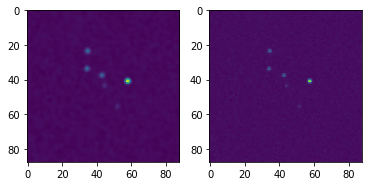

0.6


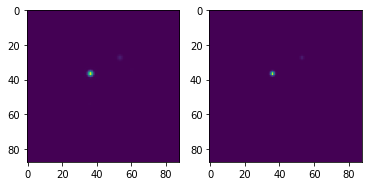

0.7


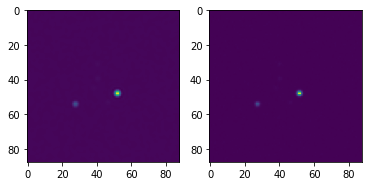

0.8


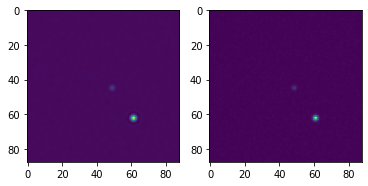

0.9


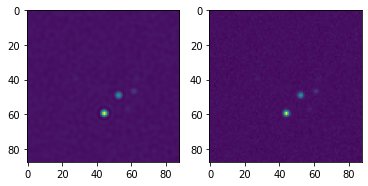

1.0


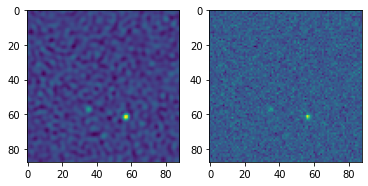

1.1


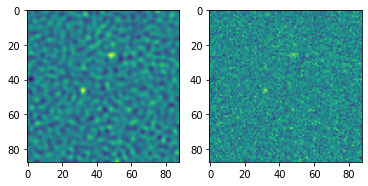

1.2000000000000002


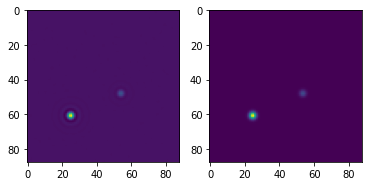

1.3


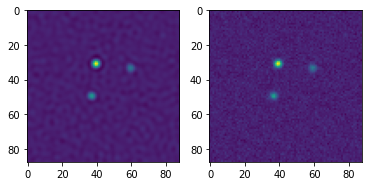

1.4


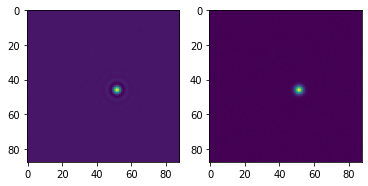

1.5


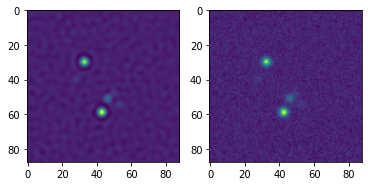

In [9]:
#generate images
for i in range(11):
    t = 0.5 + 0.1 * i
    psf_sampler = PsfSampler(t, t)
    ds_psf = GalsimBlendsSGwithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=1, psf_sampler=psf_sampler, std_psf_fwhm=0.8, valid_n_batches=1)
    
    for x in ds_psf.val_dataloader():
        print(t)
        plt.figure()
        plt.subplot(121)
        plt.imshow(x['images'][0, 0].numpy()) # plot first figure of each batch.
        plt.subplot(122)
        plt.imshow(x['noisy_image'][0, 0].numpy())
        plt.show()
    plt.close()

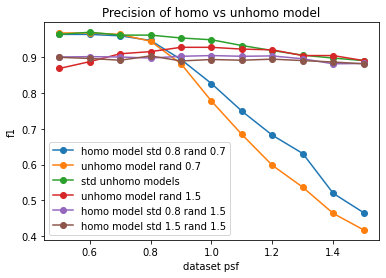

In [1]:
#draw plots
import matplotlib.pyplot as plt
import numpy as np
psfs = np.arange(0.5, 1.6, 0.1)
homo = np.array([0.963, 0.963, 0.959, 0.946, 0.893, 0.826, 0.749, 0.682, 0.631, 0.520, 0.466])
unhomo = np.array([0.967, 0.967, 0.963, 0.944, 0.881, 0.777, 0.684, 0.598, 0.537, 0.464, 0.418])
unhomo_std = np.array([0.963, 0.969, 0.961, 0.961, 0.953, 0.948, 0.932, 0.918, 0.905, 0.897, 0.890])
unhomo_rand15 = np.array([0.868, 0.887, 0.909, 0.915, 0.927, 0.927, 0.922, 0.920, 0.904, 0.904, 0.890])
homo_rand15_std08 = np.array([0.900, 0.901, 0.900, 0.897, 0.902, 0.904, 0.902, 0.903, 0.895, 0.881, 0.882])
homo_rand15_std15 = np.array([0.899, 0.896, 0.891, 0.903, 0.889, 0.893, 0.891, 0.894, 0.890, 0.886, 0.881])
plt.plot(psfs, homo, "o-", label="homo model std 0.8 rand 0.7")
plt.plot(psfs, unhomo, "o-", label="unhomo model rand 0.7")
plt.plot(psfs, unhomo_std, "o-", label="std unhomo models")
plt.plot(psfs, unhomo_rand15, "o-", label="unhomo model rand 1.5")
plt.plot(psfs, homo_rand15_std08, "o-", label="homo model std 0.8 rand 1.5")
plt.plot(psfs, homo_rand15_std15, "o-", label="homo model std 1.5 rand 1.5")
plt.xlabel("dataset psf")
plt.ylabel("f1")
plt.legend()
plt.title("Precision of homo vs unhomo model")
plt.show()

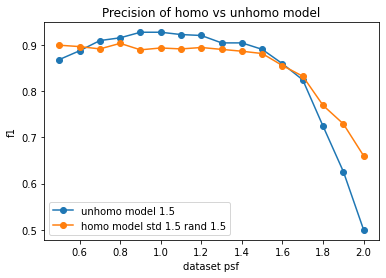

In [13]:
psfs2 = np.arange(0.5, 2.1, 0.1)
unhomo_rand15 = np.array([0.868, 0.887, 0.909, 0.915, 0.927, 0.927, 0.922, 0.920, 0.904, 0.904, 0.890, 0.859, 0.824, 0.724, 0.626, 0.500])
homo_rand15_std15 = np.array([0.899, 0.896, 0.891, 0.903, 0.889, 0.893, 0.891, 0.894, 0.890, 0.886, 0.881, 0.855, 0.832, 0.769, 0.729, 0.660])
plt.plot(psfs2, unhomo_rand15, "o-", label="unhomo model 1.5")
plt.plot(psfs2, homo_rand15_std15, "o-", label="homo model std 1.5 rand 1.5")
plt.xlabel("dataset psf")
plt.ylabel("f1")
plt.legend()
plt.title("Precision of homo vs unhomo model")
plt.show()
